In [121]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kstest
from scipy.stats import gamma, beta, norm, lognorm, t, weibull_min, expon
import scipy
import scipy.stats
import seaborn as sns
from termcolor import colored
plt.style.use('seaborn')

In the first model, we simulate the Heston model. 

\begin{equation}
\begin{split}
 & dS_{t}=\mu\,S_{t}\,dt+\sqrt{\nu_{t}}\,S_{t}\,dW^{1}_{t}\\
 &d\nu_{t}=\kappa\,(\theta-\nu_{t})\,dt+ \zeta\,\sqrt{\nu_{t}}\,dW^{2}_{t}
\end{split}
\end{equation}
Where $W^{1}_{t}$ and $W^{2}_{t}$ can be corellated Brownian motions with some mean and covariance matrix.

In our simulations, at each step of iteration, we simulate $dW_{t}$ by $\sqrt{\Delta t}\,y$ where $y$ is drawn independently from normal distribution with mean 0 and variance 1.

In [2]:
def Heston_model(s0, v0, mean, cov, mu, kappa, theta, zeta,
                 time_steps, dt, num_sim):
    
    """
    mean, cov -- parametrs of multivariate normal
    s0, v0 = price of asset and volatility at t=0.
    mu -- the rate of return.
    theta -- long run average price variance.
    kappa  -- the rate at which volatility reverts to theta.
    zeta -- volatility of volatility.
    """
    s = np.zeros(time_steps)
    v = np.zeros(time_steps)
    stock_return = np.zeros(time_steps)
    s[0], v[0] = s0, v0
    i = 1
    while i < time_steps:
        y, z = np.random.multivariate_normal(mean, cov)
        s[i] = s[i-1] + mu*s[i-1]*dt + s[i-1]*np.sqrt(v[i-1]*dt)*y
        v[i] = v[i-1] + kappa*(theta - v[i-1])*dt + zeta*np.sqrt(v[i-1]*dt)*z
        stock_return[i] = (s[i]-s[i-1])/s[i]
        i += 1
    return [s, v, stock_return]    

In [7]:
""" Feller condition: 2*kappa*theta > zeta**2"""  
mean = [0, 0]
cov = [[2,1], [1,2]]
mu = 0.1
kappa = 4
theta = 0.2
zeta = 0.2
s0 = 100
v0 = 0.02
dt = 0.01
time_steps = 200
num_sim = 3000

simulation = [Heston_model(s0, v0, mean, cov, mu, kappa, theta, zeta,
                 time_steps, dt, j) for j in range(num_sim)]
simulation = np.asarray(simulation)
s_mean = np.mean(simulation[:,0], axis=0)
v_mean = np.mean(simulation[:,1], axis=0)

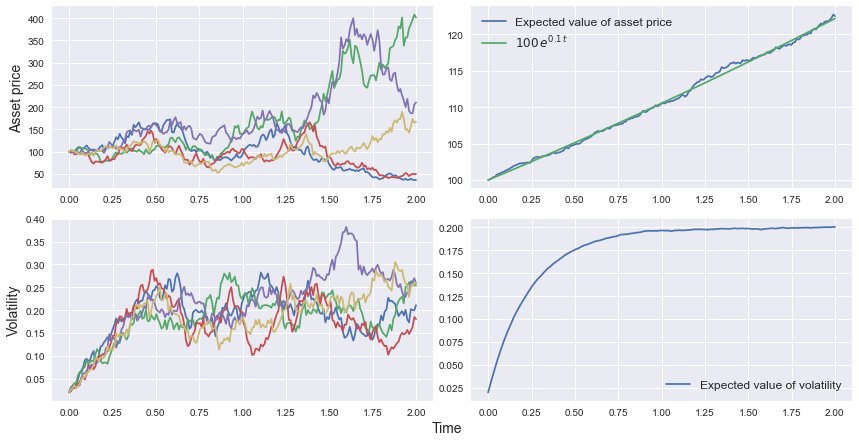

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(12,6))
t = np.linspace(0, time_steps*dt, time_steps)
ax[0,1].plot(t, s_mean, label='Expected value of asset price')
ax[0,1].plot(t, 100*np.exp(mu*t), label=r'$100\,e^{0.1\,t}$')
ax[1,1].plot(t, v_mean, label='Expected value of volatility')
for i in range(5):
    ax[0,0].plot(t, simulation[i,0])
    ax[1,0].plot(t, simulation[i,1])
ax[0,0].set_ylabel('Asset price', fontsize=14)
ax[1,0].set_ylabel('Volatility', fontsize=14)
ax[0,1].legend(fontsize=12)
ax[1,1].legend(fontsize=12)  
fig.text(0.5,-0.01,'Time', fontsize=14)
plt.tight_layout()

As we can see from the plots, The expected value of $S_t$ is $S_{0}\,e^{\mu\,t}=100\,e^{0.1\,t}$. Moreover the mean of volatility converges to $\theta=0.2$, this property of volatility is called **mean reversion**. It reverts to the long-run mean.

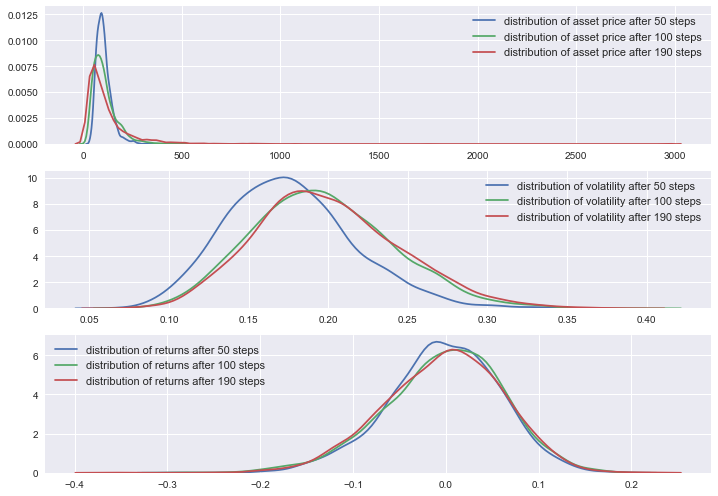

In [12]:
fig, ax = plt.subplots(3, figsize=(10,7))
time = [50, 100, 190]
for i in range(3):
    sns.kdeplot(simulation[:,0][:,time[i]], 
                label='distribution of asset price after {} steps'.format(time[i]), ax=ax[0])
    sns.kdeplot(simulation[:,1][:,time[i]], 
                label='distribution of volatility after {} steps'.format(time[i]), ax=ax[1])
    sns.kdeplot(simulation[:,2][:,time[i]], 
                label='distribution of returns after {} steps'.format(time[i]), ax=ax[2])
ax[0].legend(fontsize=11)
ax[1].legend(fontsize=11)
ax[2].legend(fontsize=11)
plt.tight_layout()

We find the distribution of above plots using **Kolmogorov-Smirnov test**. First, we fit the data to the known distributions and then we compare the **statistics** and **p-values** of each case by Kolmogorov-Smirnov test. 
In the next cell, we have fitted asset prices at $t=1$ ( after $100$ time-steps ) with $7$ distributions. 

In [198]:
"""Distribution of asset price"""

dist_names = ['gamma', 'beta', 'norm', 't', 'lognorm', 'weibull_min', 'expon']
param={}

for i, dist_name in enumerate(dist_names):
    dist = getattr(scipy.stats, dist_name)
    param[i] = dist.fit(y)
    test = kstest(simulation[:,0][:,100], dist_names[i], [*param[i]])
    print(colored('{} distribution parameters:','red').format(dist_names[i]),
          param[i],colored('and', 'blue'), test)    
    

gamma distribution parameters: (0.2191208478357437, 15.056726666560891, 2.327123175317073) and KstestResult(statistic=0.9954263603677843, pvalue=0.0)
beta distribution parameters: (2.5704391280870595, 9382076.989823824, 14.639060250427946, 347697365.31801736) and KstestResult(statistic=0.039240332626891195, pvalue=0.00018889370442507354)
norm distribution parameters: (110.6329087063382, 68.97408614841117) and KstestResult(statistic=0.1303251694868217, pvalue=6.91496656105652e-45)
t distribution parameters: (2.919026273352979, 95.6394424725047, 40.69621949936527) and KstestResult(statistic=0.0904237294338158, pvalue=8.542022053961998e-22)
lognorm distribution parameters: (3.6773568591092984, 15.056725423727386, 0.9336338101596673) and KstestResult(statistic=0.7696614019685313, pvalue=0.0)
weibull_min distribution parameters: (0.2330988549688144, 15.056726666560891, 2.8095847252663413) and KstestResult(statistic=0.7660445375300787, pvalue=0.0)
expon distribution parameters: (15.056726666

We choose the distributions with less statistics and greater p-value. Beta distribution seems to have the closest distribution to data as it has the least statistics and the greatest p-value among 7 distributions. Normal and exponential distributions also could be next candidates for the true distribution but as we can see in the next plot, beta distribution is the best fit to the asset price at $t=1$.

I have plotted these 3 distribution in the next cell.

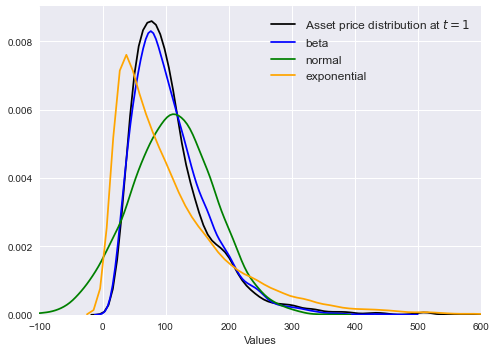

In [202]:
fig, ax = plt.subplots(1, figsize=(7,5))
y = simulation[:,0][:,100]

gamma_samples = gamma.rvs(*param[0], size=10000)
beta_samples = beta.rvs(*param[1], size=10000)
norm_samples = norm.rvs(*param[2], size=10000)
t_samples = t.rvs(*param[3], size=10000)
lognorm_samples = lognorm.rvs(*param[4], size=10000)
weibul_samples = weibull_min.rvs(*param[5], size=10000)
expon_samples = expon.rvs(*param[6], size=10000)

sns.kdeplot(y, label='Asset price distribution at $t=1$', color='black')
sns.kdeplot(beta_samples, label='beta', color='blue')
sns.kdeplot(norm_samples, label='normal', color='green')
sns.kdeplot(expon_samples, label='exponential', color='orange')
ax.legend(fontsize=12)
ax.set_xlabel('Values')
ax.set_xlim([-100,600])
plt.tight_layout()

In the next cell I have done the same experiment for volatility distribution after $100$ time-steps or at $t=1$. 

In [146]:
"""Distribution of volatility"""

dist_names = ['gamma', 'beta', 'norm', 't', 'lognorm', 'weibull_min', 'expon']
param={}

for i, dist_name in enumerate(dist_names):
    dist = getattr(scipy.stats, dist_name)
    param[i] = dist.fit(y)
    test = kstest(simulation[:,1][:,100], dist_names[i], [*param[i]])
    print(colored('{} distribution parameters:','red').format(dist_names[i]),
          param[i],colored('and', 'blue'), test)    
    

gamma distribution parameters: (25.598747062657026, -0.0255911761633077, 0.008682582469517426) and KstestResult(statistic=0.00754952462417624, pvalue=0.9950934937893301)
beta distribution parameters: (10.57965387771409, 34.75477743301336, 0.03184477260943841, 0.7062921910534857) and KstestResult(statistic=0.00687537509044811, pvalue=0.9987387032922699)
norm distribution parameters: (0.19667205861140874, 0.043879120420726496) and KstestResult(statistic=0.02941340672306947, pvalue=0.010911138804358221)
t distribution parameters: (74.27667775653558, 0.1964706532208389, 0.04328347023893345) and KstestResult(statistic=0.026941387976580744, pvalue=0.025217188352203768)
lognorm distribution parameters: (0.13108754049858062, -0.1370039200782812, 0.3308223739730157) and KstestResult(statistic=0.00796624676512192, pvalue=0.9904446583491712)
weibull_min distribution parameters: (2.885885369927852, 0.07879390171452974, 0.13215242415978962) and KstestResult(statistic=0.020533136181585254, pvalue=0.

Log-normal, beta and gamma distributions are perfect candidates for the true distribution. Therefore we can say that volatility at $t=1$ has a log-normal distribution.

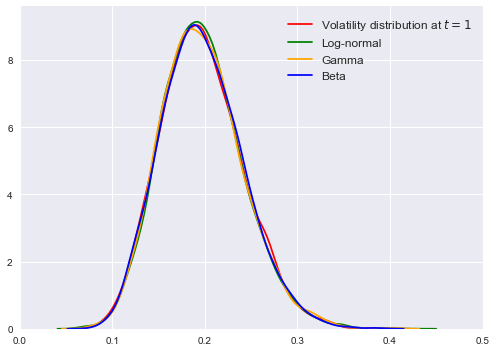

In [156]:
fig, ax = plt.subplots(1, figsize=(7,5))
y = simulation[:,1][:,100]

gamma_samples = gamma.rvs(*param[0], size=10000)
beta_samples = beta.rvs(*param[1], size=10000)
norm_samples = norm.rvs(*param[2], size=10000)
t_samples = t.rvs(*param[3], size=10000)
lognorm_samples = lognorm.rvs(*param[4], size=10000)
weibul_samples = weibull_min.rvs(*param[5], size=10000)
expon_samples = expon.rvs(*param[6], size=10000)

sns.kdeplot(y, label='Volatility distribution at $t=1$', color='red')
sns.kdeplot(lognorm_samples, label='Log-normal', color='green')
sns.kdeplot(gamma_samples, label='Gamma', color='orange')
sns.kdeplot(beta_samples, label='Beta', color='blue')
ax.legend(fontsize=12)
ax.set_xlim([0,0.5])
plt.tight_layout()

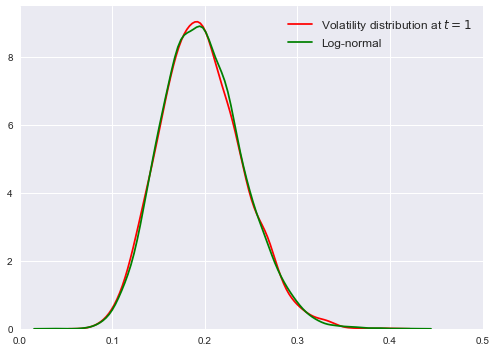

In [155]:
fig, ax = plt.subplots(1, figsize=(7,5))
y = simulation[:,1][:,100]
lognorm_samples = lognorm.rvs(*param[4], size=10000)
sns.kdeplot(y, label='Volatility distribution at $t=1$', color='red')
sns.kdeplot(lognorm_samples, label='Log-normal', color='green')
ax.legend(fontsize=12)
ax.set_xlim([0,0.5])
plt.tight_layout()

Finally, we do the same experiment to the stock returns at $t=1$.

In [207]:
"""Distribution of returns"""

dist_names = ['gamma', 'beta', 'norm', 't', 'lognorm', 'weibull_min', 'expon']
param={}

for i, dist_name in enumerate(dist_names):
    dist = getattr(scipy.stats, dist_name)
    param[i] = dist.fit(y)
    test = kstest(simulation[:,2][:,100], dist_names[i], [*param[i]])
    print(colored('{} distribution parameters:','red').format(dist_names[i]),
          param[i],colored('and', 'blue'), test)    
    

gamma distribution parameters: (338.1916093927932, -1.1943734687568734, 0.003524222972694332) and KstestResult(statistic=0.04345902849215438, pvalue=2.318777145903759e-05)
beta distribution parameters: (12053904.808814958, 19.874569256830092, -175323.57354883582, 175323.86062229885) and KstestResult(statistic=0.015929352337282987, pvalue=0.42741117748461444)
norm distribution parameters: (-0.0019753965410440957, 0.06412561951227777) and KstestResult(statistic=0.03256650873345873, pvalue=0.0033692529391224613)
t distribution parameters: (20.8853355097666, -0.0009556333599901969, 0.06098210653098429) and KstestResult(statistic=0.02651499770066912, pvalue=0.02892199201993062)
lognorm distribution parameters: (0.004872603610069932, -13.110881358498958, 13.10906035637602) and KstestResult(statistic=0.031401483296849275, pvalue=0.0052739776898752585)
weibull_min distribution parameters: (6.247109154265685, -0.34885560255128056, 0.372812232347141) and KstestResult(statistic=0.0158168450535522

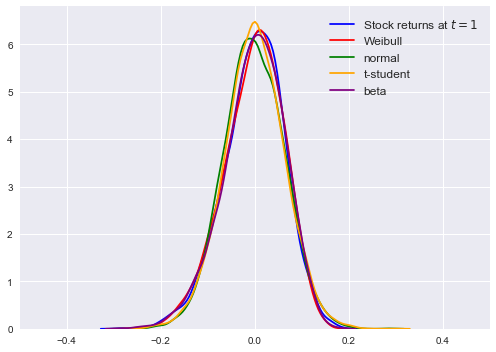

In [208]:
fig, ax = plt.subplots(1, figsize=(7,5))
y = simulation[:,2][:,100]

gamma_samples = gamma.rvs(*param[0], size=10000)
beta_samples = beta.rvs(*param[1], size=10000)
norm_samples = norm.rvs(*param[2], size=10000)
t_samples = t.rvs(*param[3], size=10000)
lognorm_samples = lognorm.rvs(*param[4], size=10000)
weibull_samples = weibull_min.rvs(*param[5], size=10000)
expon_samples = expon.rvs(*param[6], size=10000)


sns.kdeplot(y, label='Stock returns at $t=1$', color='blue')
sns.kdeplot(weibull_samples, label='Weibull', color='red')
sns.kdeplot(norm_samples, label='normal', color='green')
sns.kdeplot(t_samples, label='t-student', color='orange')
sns.kdeplot(beta_samples, label='beta', color='purple')
ax.legend(fontsize=12)
ax.set_xlim([-0.5,0.5])
plt.tight_layout()
    

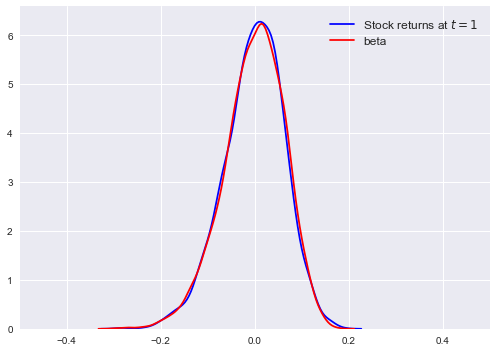

In [210]:
fig, ax = plt.subplots(1, figsize=(7,5))
y = simulation[:,2][:,100]
beta_samples = beta.rvs(*param[1], size=10000)
sns.kdeplot(y, label='Stock returns at $t=1$', color='blue')
sns.kdeplot(beta_samples, label='beta', color='red')
ax.legend(fontsize=12)
ax.set_xlim([-0.5,0.5])
plt.tight_layout()

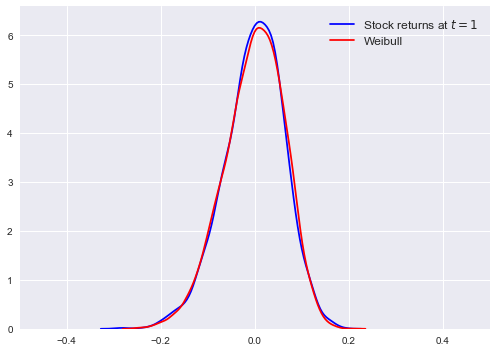

In [211]:
fig, ax = plt.subplots(1, figsize=(7,5))
y = simulation[:,2][:,100]
weibull_samples = weibull_min.rvs(*param[5], size=10000)
sns.kdeplot(y, label='Stock returns at $t=1$', color='blue')
sns.kdeplot(weibull_samples, label='Weibull', color='red')
ax.legend(fontsize=12)
ax.set_xlim([-0.5,0.5])
plt.tight_layout()

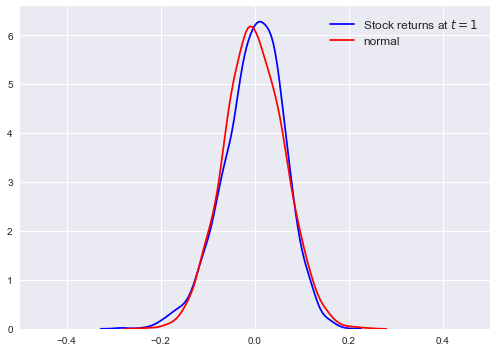

In [212]:
fig, ax = plt.subplots(1, figsize=(7,5))
y = simulation[:,2][:,100]
normal_samples = norm.rvs(*param[2], size=10000)
sns.kdeplot(y, label='Stock returns at $t=1$', color='blue')
sns.kdeplot(normal_samples, label='normal', color='red')
ax.legend(fontsize=12)
ax.set_xlim([-0.5,0.5])
plt.tight_layout()